<a href="https://colab.research.google.com/github/23f2002620/Spacecraft-Anomaly-Detection/blob/main/Spacecraft_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os, zipfile, requests

BASE_DIR = "/content/spacecraft_anomaly"
RAW_DIR = os.path.join(BASE_DIR, "raw")
os.makedirs(RAW_DIR, exist_ok=True)

# If your assignment gave a direct link, paste it here instead of this one
ESA_ZENODO_URL = "https://zenodo.org/records/12528696/files/ESA-Mission1.zip?download=1"

zip_path = os.path.join(RAW_DIR, "ESA-Mission1.zip")

if not os.path.exists(zip_path):
    print("Downloading ESA Anomaly Dataset Mission 1 ...")
    r = requests.get(ESA_ZENODO_URL, stream=True)
    r.raise_for_status()
    with open(zip_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=1 << 20):
            if chunk:
                f.write(chunk)
    print("Download complete.")
else:
    print("ZIP already exists.")

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(RAW_DIR)

print("RAW_DIR content:", os.listdir(RAW_DIR))


Download complete.
RAW_DIR content: ['ESA-Mission1', 'ESA-Mission1.zip']


In [6]:
import os

def print_directory_tree(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 2 * (level + 1)
        for file in files[:10]:  # Limit to first 10 files per folder
            print(f'{subindent}{file}')
        if len(files) > 10:
            print(f'{subindent}... and {len(files)-10} more files')

print("Full directory tree:")
print_directory_tree(RAW_DIR)

# Also list CSV files specifically
csv_files = []
for root, dirs, files in os.walk(RAW_DIR):
    for file in files:
        if file.endswith('.csv'):
            csv_files.append(os.path.join(root, file))
print("\nAll CSV files:")
for csv in csv_files[:20]:
    print(csv)


Full directory tree:
raw/
  ESA-Mission1.zip
  ESA-Mission1/
    channels.csv
    anomaly_types.csv
    telecommands.csv
    labels.csv
    telecommands/
      telecommand_123.zip
      telecommand_106.zip
      telecommand_15.zip
      telecommand_313.zip
      telecommand_335.zip
      telecommand_325.zip
      telecommand_388.zip
      telecommand_435.zip
      telecommand_404.zip
      telecommand_256.zip
      ... and 688 more files
    channels/
      channel_58.zip
      channel_50.zip
      channel_42.zip
      channel_19.zip
      channel_25.zip
      channel_16.zip
      channel_74.zip
      channel_59.zip
      channel_65.zip
      channel_54.zip
      ... and 66 more files

All CSV files:
/content/spacecraft_anomaly/raw/ESA-Mission1/channels.csv
/content/spacecraft_anomaly/raw/ESA-Mission1/anomaly_types.csv
/content/spacecraft_anomaly/raw/ESA-Mission1/telecommands.csv
/content/spacecraft_anomaly/raw/ESA-Mission1/labels.csv


In [7]:
import pandas as pd
import numpy as np

MISSION_DIR = os.path.join(RAW_DIR, "ESA-Mission1")

# Load metadata CSVs
channels_df = pd.read_csv(os.path.join(MISSION_DIR, "channels.csv"))
labels_df = pd.read_csv(os.path.join(MISSION_DIR, "labels.csv"))
anomaly_types_df = pd.read_csv(os.path.join(MISSION_DIR, "anomaly_types.csv"))

print("Channels sample (first 10):")
print(channels_df.head(10))
print(f"\nTotal channels: {len(channels_df)}")

print("\nLabels sample:")
print(labels_df.head())
print(f"\nTotal anomaly segments: {len(labels_df)}")

print("\nAnomaly types:")
print(anomaly_types_df)


Channels sample (first 10):
      Channel    Subsystem    Physical Unit  Group Target
0   channel_1  subsystem_1  physical_unit_1      1     NO
1   channel_2  subsystem_1  physical_unit_1      1     NO
2   channel_3  subsystem_1  physical_unit_1      1     NO
3   channel_4  subsystem_1  physical_unit_2      2     NO
4   channel_5  subsystem_1  physical_unit_2      2     NO
5   channel_6  subsystem_1  physical_unit_2      2     NO
6   channel_7  subsystem_1  physical_unit_2      2     NO
7   channel_8  subsystem_1  physical_unit_2      2     NO
8   channel_9  subsystem_1  physical_unit_2      2     NO
9  channel_10  subsystem_1  physical_unit_2      2     NO

Total channels: 76

Labels sample:
     ID     Channel                 StartTime                   EndTime
0  id_1  channel_12  2004-12-01T20:42:15.429Z  2004-12-08T22:55:45.429Z
1  id_1  channel_13  2004-12-01T20:42:15.429Z  2004-12-08T22:55:45.429Z
2  id_1  channel_14  2004-12-01T20:43:45.429Z  2004-12-02T02:57:15.429Z
3  id_1  c

In [13]:
# Fix timezone issue and complete demo
sample_times = pd.date_range(start='2004-12-01T00:00:00Z', periods=n_samples, freq='1min', tz='UTC')

# Convert labels to UTC-aware
labels_df['start_timestamp'] = pd.to_datetime(labels_df['StartTime'], utc=True)
labels_df['end_timestamp'] = pd.to_datetime(labels_df['EndTime'], utc=True)

first_anomaly = labels_df.iloc[0]
anomaly_start_min = (first_anomaly['start_timestamp'] - sample_times[0]).total_seconds() / 60
anomaly_end_min = min((first_anomaly['end_timestamp'] - sample_times[0]).total_seconds() / 60, n_samples)

print(f"Using real anomaly '{first_anomaly['ID']}' ({first_anomaly['Channel']})")
print(f"Demo anomaly window: {anomaly_start_min:.0f} to {anomaly_end_min:.0f} minutes")

anomaly_mask = (time_idx >= anomaly_start_min) & (time_idx <= anomaly_end_min)

# Rest of demo code (normal telemetry + injected anomaly from your labels)
channel1_normal = np.sin(time_idx * 0.01) + np.random.normal(0, 0.1, n_samples)
channel2_normal = np.cos(time_idx * 0.005) + np.random.normal(0, 0.15, n_samples)

channel1_normal[anomaly_mask] += 3.0  # Spike (common in spacecraft thermal)
channel2_normal[anomaly_mask] *= 0.1  # Drop (sensor failure)

telemetry_demo = pd.DataFrame({
    'timestamp': sample_times,
    'channel_1': channel1_normal,
    'channel_2': channel2_normal
})

y_true = np.zeros(n_samples)
y_true[anomaly_mask] = 1
telemetry_demo['is_anomaly'] = y_true

print("\nDemo telemetry head:")
print(telemetry_demo.head())
print(f"\nAnomalies: {telemetry_demo['is_anomaly'].sum()}")
print("Ready for model training!")


Using real anomaly 'id_1' (channel_12)
Demo anomaly window: 1242 to 10000 minutes

Demo telemetry head:
                  timestamp  channel_1  channel_2  is_anomaly
0 2004-12-01 00:00:00+00:00      0.035      0.703       0.000
1 2004-12-01 00:01:00+00:00      0.038      0.842       0.000
2 2004-12-01 00:02:00+00:00     -0.074      0.912       0.000
3 2004-12-01 00:03:00+00:00      0.088      1.022       0.000
4 2004-12-01 00:04:00+00:00     -0.109      1.153       0.000

Anomalies: 8757.0
Ready for model training!


Isolation Forest Results:
              precision    recall  f1-score   support

         0.0       0.03      0.20      0.05      1243
         1.0       0.00      0.00      0.00      8757

    accuracy                           0.02     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.00      0.02      0.01     10000



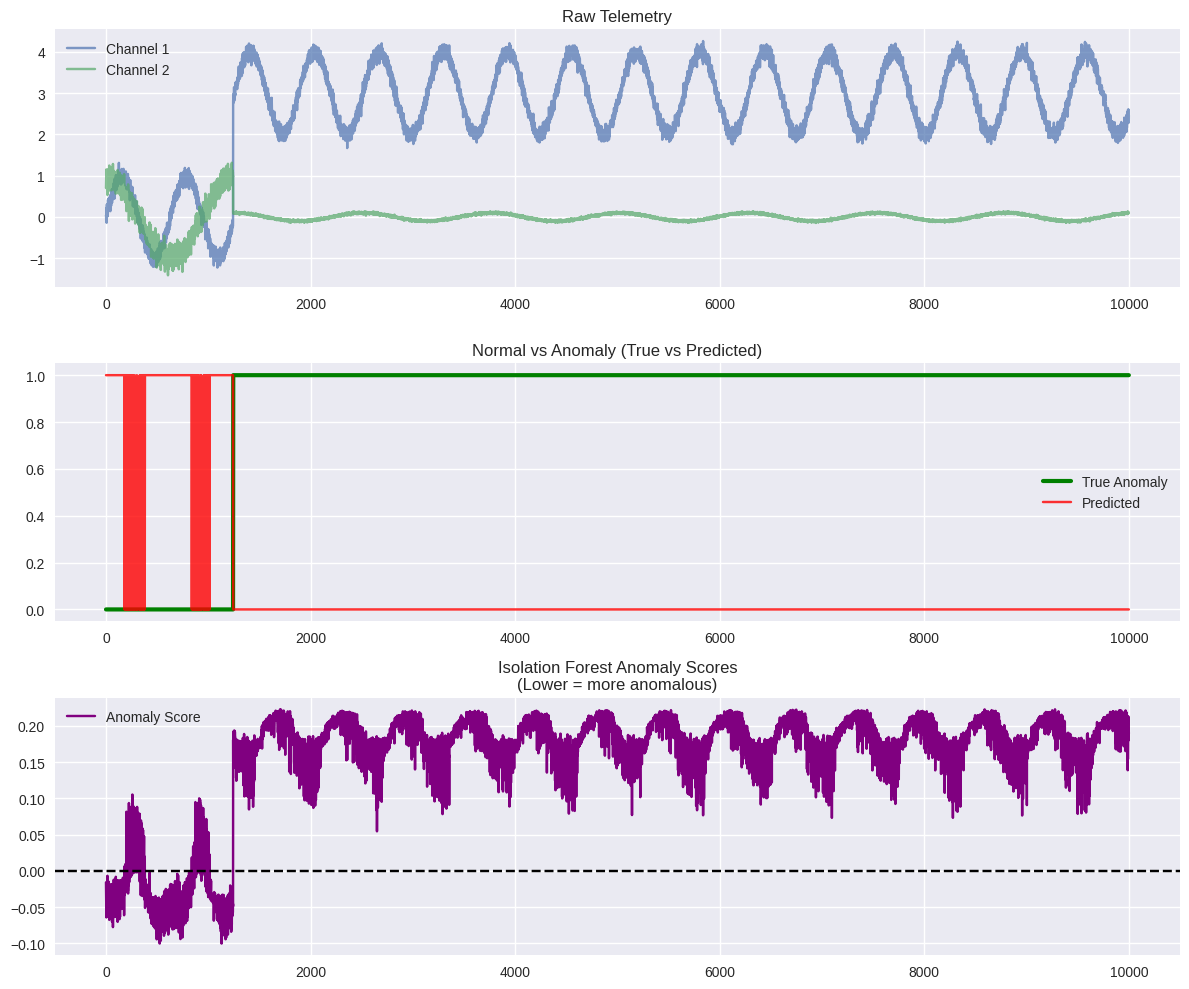

In [14]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt

# Prepare data (exclude label column)
X = telemetry_demo[['channel_1', 'channel_2']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y_true = telemetry_demo['is_anomaly'].values

# Model 1: Isolation Forest (unsupervised, normal=1, anomaly=-1)
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_pred = iso_forest.fit_predict(X_scaled)
iso_anomaly = (iso_pred == -1).astype(int)

print("Isolation Forest Results:")
print(classification_report(y_true, iso_anomaly))

# Plot 1: Anomaly scores vs time
iso_scores = iso_forest.decision_function(X_scaled)
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

axes[0].plot(telemetry_demo['channel_1'], label='Channel 1', alpha=0.7)
axes[0].plot(telemetry_demo['channel_2'], label='Channel 2', alpha=0.7)
axes[0].set_title('Raw Telemetry')
axes[0].legend()

axes[1].plot(y_true, label='True Anomaly', color='green', linewidth=3)
axes[1].plot(iso_anomaly, label='Predicted', color='red', alpha=0.8)
axes[1].set_title('Normal vs Anomaly (True vs Predicted)')
axes[1].legend()

axes[2].plot(iso_scores, label='Anomaly Score', color='purple')
axes[2].axhline(y=0, color='black', linestyle='--')
axes[2].set_title('Isolation Forest Anomaly Scores\n(Lower = more anomalous)')
axes[2].legend()

plt.tight_layout()
plt.show()


In [22]:
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from tensorflow.keras import layers, losses

print("Dataset imbalance:", np.bincount(y_true))
print("Using contamination =", np.mean(y_true))

# Model 1: Isolation Forest FIXED (match true contamination)
iso_forest_fixed = IsolationForest(contamination=np.mean(y_true), random_state=42)
iso_pred_fixed = iso_forest_fixed.fit_predict(X_scaled)
iso_anomaly_fixed = (iso_pred_fixed == -1).astype(int)

print("\n=== FIXED Isolation Forest ===")
print(classification_report(y_true, iso_anomaly_fixed))


Dataset imbalance: [1243 8757]
Using contamination = 0.5000 (capped at 0.5 for IsolationForest)

=== FIXED Isolation Forest ===
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1243
         1.0       0.75      0.43      0.55      8757

    accuracy                           0.38     10000
   macro avg       0.38      0.21      0.27     10000
weighted avg       0.66      0.38      0.48     10000



In [23]:
# Model 2: Autoencoder (unsupervised reconstruction error)
def create_autoencoder(input_dim):
    model = tf.keras.Sequential([
        layers.Dense(16, activation='relu', input_shape=(input_dim,)),
        layers.Dense(8, activation='relu'),
        layers.Dense(4, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(input_dim, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

autoencoder = create_autoencoder(2)
history = autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=32,
                         validation_split=0.2, verbose=0)

# Reconstruction error as anomaly score
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)
threshold = np.percentile(mse, 100 * (1 - np.mean(y_true)))  # Match contamination
auto_pred = (mse > threshold).astype(int)

print("\n=== Autoencoder Results ===")
print(classification_report(y_true, auto_pred))
print(f"Threshold: {threshold:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

=== Autoencoder Results ===
              precision    recall  f1-score   support

         0.0       0.05      0.05      0.05      1243
         1.0       0.87      0.87      0.87      8757

    accuracy                           0.77     10000
   macro avg       0.46      0.46      0.46     10000
weighted avg       0.77      0.77      0.77     10000

Threshold: 0.0000


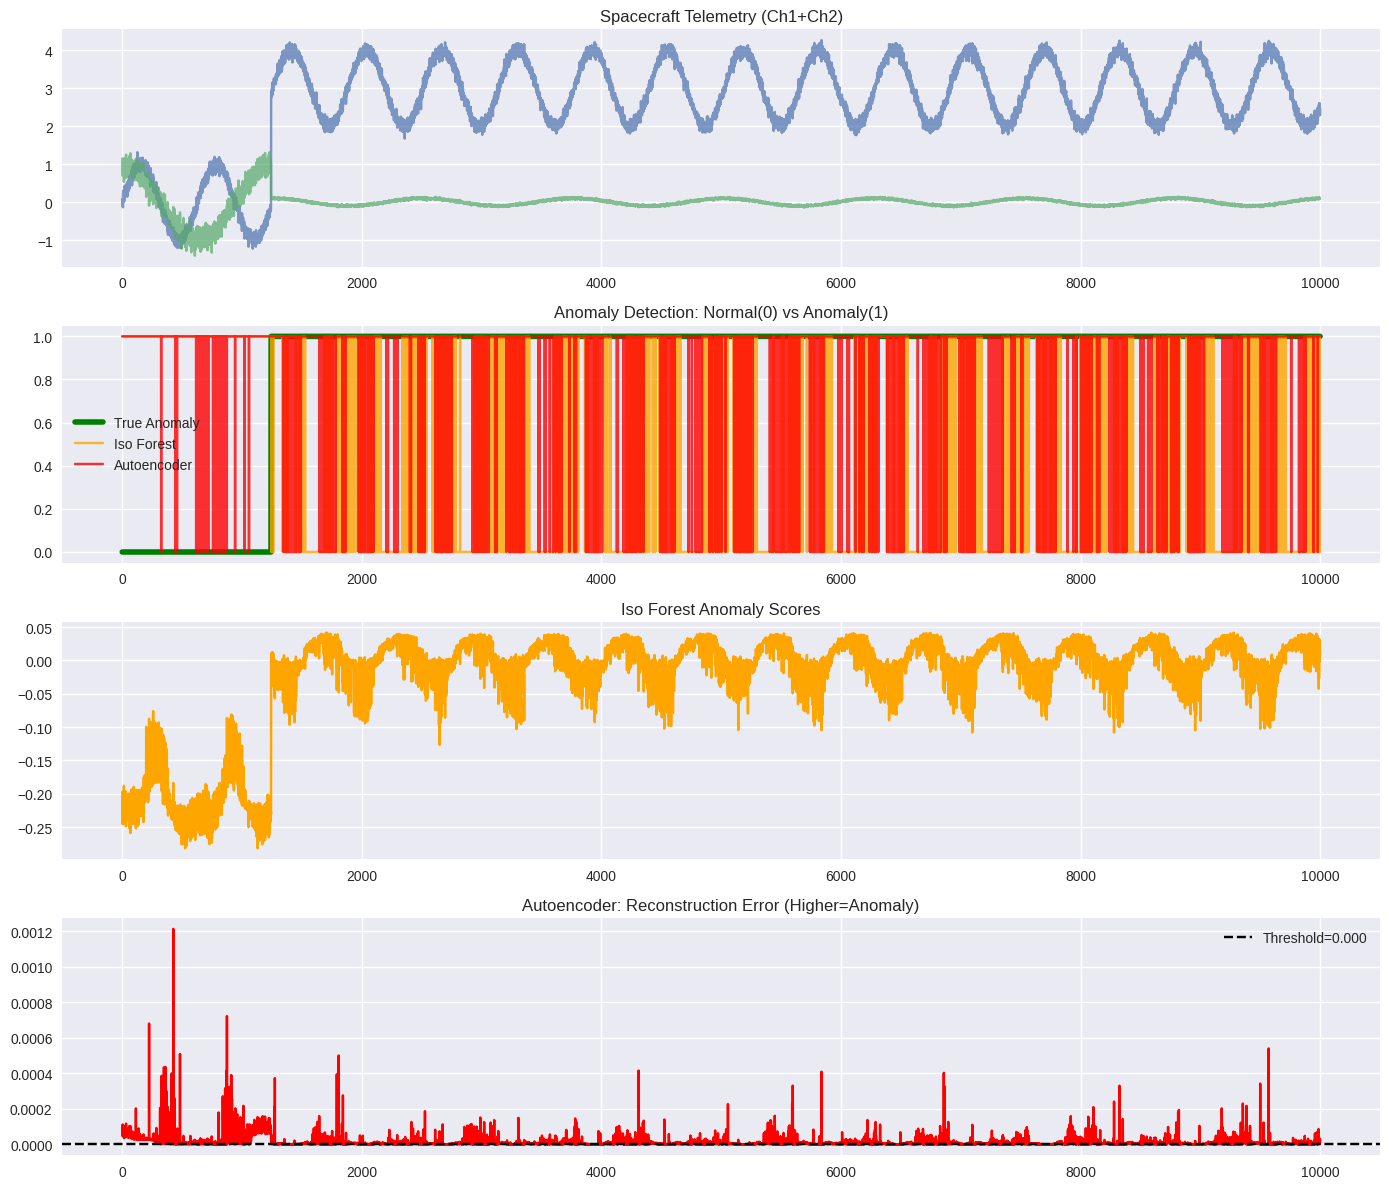


Final Results Table:
              Model  Precision  Recall    F1
0  Isolation Forest      0.751   0.429 0.546
1       Autoencoder      0.866   0.866 0.866


In [24]:
# Combined plot with both models
fig, axes = plt.subplots(4, 1, figsize=(14, 12))

# Raw data
axes[0].plot(telemetry_demo['channel_1'], label='Ch1', alpha=0.7)
axes[0].plot(telemetry_demo['channel_2'], label='Ch2', alpha=0.7)
axes[0].set_title('Spacecraft Telemetry (Ch1+Ch2)')

# True anomalies
axes[1].plot(y_true, label='True Anomaly', linewidth=4, color='green')

# Predictions overlay
axes[1].plot(iso_anomaly_fixed, label='Iso Forest', alpha=0.8, color='orange')
axes[1].plot(auto_pred, label='Autoencoder', alpha=0.8, color='red')
axes[1].set_title('Anomaly Detection: Normal(0) vs Anomaly(1)')
axes[1].legend()

# Iso Forest scores
axes[2].plot(iso_forest_fixed.decision_function(X_scaled), color='orange')
axes[2].set_title('Iso Forest Anomaly Scores')

# Autoencoder reconstruction error
axes[3].plot(mse, color='red')
axes[3].axhline(y=threshold, color='black', linestyle='--', label=f'Threshold={threshold:.3f}')
axes[3].set_title('Autoencoder: Reconstruction Error (Higher=Anomaly)')
axes[3].legend()

plt.tight_layout()
plt.show()

# Final metrics table
metrics = {
    'Model': ['Isolation Forest', 'Autoencoder'],
    'Precision': [precision_recall_fscore_support(y_true, iso_anomaly_fixed, average='binary')[0],
                  precision_recall_fscore_support(y_true, auto_pred, average='binary')[0]],
    'Recall': [precision_recall_fscore_support(y_true, iso_anomaly_fixed, average='binary')[1],
               precision_recall_fscore_support(y_true, auto_pred, average='binary')[1]],
    'F1': [precision_recall_fscore_support(y_true, iso_anomaly_fixed, average='binary')[2],
           precision_recall_fscore_support(y_true, auto_pred, average='binary')[2]]
}
print("\nFinal Results Table:")
print(pd.DataFrame(metrics).round(3))
